# Problem Description
------

![alt text](https://raw.githubusercontent.com/bfitzpa5/side_projects/master/tvision_logo.PNG)

### Description
TVision uses Automatic Content Recognition (ACR) to identify which content is running on screen at any given moment.  The data returns a Content ID which may be associated with an episode, a movie or an "other" type of content.  Metadata associated with each Content ID is provided by a third party and examples are included for each type in the attached tabs.
Each piece of content is "tagged" with a selection of as many as 6 genre-related pieces of information.
The genre tags are not provided with any specific hierarchy.

### Objective
Increase the usability of TVision data by creating a standardized set of Genre assignments.

### Questions
1. Can you use the information provided to simplify to a single genre assignment per content ID?
2. What are your primary considerations in reaching this assignment?
3. Is there a hierarchy that can be inferred from the remaining unstructured information that is provided?
4. What other data can be extracted that might be of use to clients looking to analyze TV performance?
5. How would your approach differ if you were to approach this as a one-time analytical exercise vs. an ongoing data processing need?


# _Responses_
------


In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import ast
import matplotlib.pyplot as plt
import seaborn as sns

### Question 1

1. _Can you use the information provided to simplify to a single genre assignment per content ID?_

In [2]:
df = (pd.read_excel(r'Data/Genre Assignment Project.xlsx', 'Episode Data')
      .assign(genres=lambda x: x.genres.apply(lambda row: ast.literal_eval(row)),
              genre_count=lambda x: x.genres.apply(lambda row: len(row))))

We'll split out all words into count variables to make the data more manageable using sklearn's count vectorizer.

In [3]:
cv = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
x = cv.fit_transform(df.genres)
df = pd.concat([df, pd.DataFrame(x.toarray(), columns=cv.get_feature_names())], axis=1)

We now have added dummy variable columns for each of the possible genre values. See the below for an example as the third row has all ones for each value

In [4]:
print("There are %d distinct genre values" % len(cv.get_feature_names()))

There are 391 distinct genre values


Let's take a look at the distribution of word counts per episode

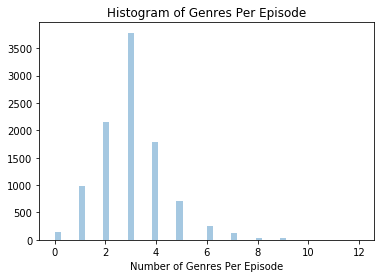

In [5]:
ax = sns.distplot(df.genre_count, kde=False)
ax.set(xlabel='Number of Genres Per Episode', title='Histogram of Genres Per Episode')
plt.show()

In [6]:
(df.genre_count
 .describe()
 .pipe(pd.DataFrame)
 .rename(columns={'genre_count': 'Episode Word Counts'}))

,Episode Word Counts
count,10000.000000
mean,3.030700
std,1.354748
min,0.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,12.000000


We can see from the above that the most common number of words is 3. 
Generally, it is normally distributed with a slight right skew.

What we can take from this is that we would only have 3 shots at getting the genre right on an episode-by-episode basis.

#### Total Word Counts

In [7]:
df_wc = (df.loc[:, cv.get_feature_names()].sum()
         .reset_index()
         .rename(columns={'index': 'genre', 0: 'count'}))

In [8]:
(df_wc.set_index('genre')
 .sort_index()
 .to_excel(r'Data/word_counts.xlsx'))

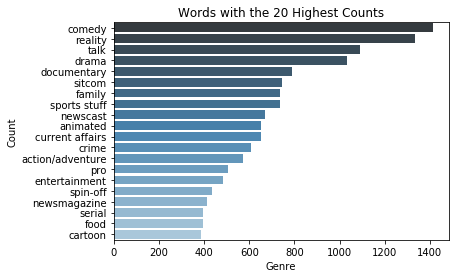

In [9]:
ax = (df_wc.nlargest(20, 'count')
      .pipe((sns.barplot, 'data'), x='count', y='genre', palette="Blues_d"))
ax.set(xlabel='Genre', ylabel = 'Count', title='Words with the 20 Highest Counts')
plt.show()

In [10]:
single_count_words = df_wc.query('count == 1').shape[0]
total_words = df_wc.shape[0]
percent_single = single_count_words / total_words * 100
print("{:0.2f}% of the words only show up once.\n"
      "These are garbage words that we can presumably ignore.".format(percent_single))

24.55% of the words only show up once.
These are garbage words that we can presumably ignore.


#### Series Analysis

We have some _Series ID_'s and _Series Name_'s with NaNs per the below.

In [11]:
mask = df.series_name.apply(lambda x: not isinstance(x, str))
cols = ['series_id', 'series_name']
print("There are {:,d} Series ID/Series Name errors".format(df.loc[mask, ].shape[0]))
df.loc[mask, cols].head()

There are 28 Series ID/Series Name errors


,series_id,series_name
197,NaN,NaN
807,NaN,NaN
1758,915050636.0,227
1918,915050636.0,227
2241,NaN,NaN


We'll drop these for now as there aren't that many and to stay on task, but noting as we'll address it later.

In [12]:
# remove series with NaNs for series name
mask = df.series_name.apply(lambda x: isinstance(x, str))
df = (df.loc[mask, :]
      .assign(series_id=lambda x: x.series_id.astype('int64')))

In [13]:
excluded_cols = ['content_id', 'title', 'original_airdate', 'description', 'season_number', 'episode_number_in_series',
                 'episode_number_in_season', 'genres']
dims = ['series_id', 'series_name']
measures = cv.get_feature_names()
assert(len(measures) == 391) # sanity check as we know from the above that we have 391 distinct words
df_series = df.groupby(dims)[measures].sum()

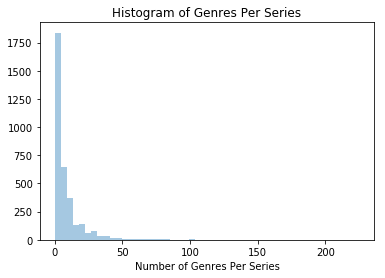

In [14]:
ax = (df_series.sum(axis=1)
      .pipe(sns.distplot, kde=False))
ax.set(xlabel='Number of Genres Per Series', title='Histogram of Genres Per Series')
plt.show()

Heavy right skew for genres per series. We have a lot more data to work with on a series-by-series basis compared to episodes-by-episode.

Most fall between 0-50 with the largest majority less than 10.

In [15]:
(df_series.sum(axis=1)
 .describe()
 .pipe(pd.DataFrame)
 .rename(columns={0: 'Series Word Counts'}))

,Series Word Counts
count,3427.000000
mean,8.824336
std,13.373985
min,0.000000
25%,3.000000
50%,4.000000
75%,9.000000
max,225.000000


Let's take at the series with highest counts of distinct words look at the top 15

In [16]:
(df_series.sum(axis=1)
 .nlargest(15)
 .astype('int64')
 .pipe(pd.DataFrame)
 .rename(columns={0: 'Count of Genres'}))

,,Count of Genres
series_id,series_name,
913965072,The Amazing World of Gumball,225
915975543,SportsCenter,170
903606529,Teen Titans Go!,160
914312434,Law & Order: Special Victims Unit,138
4334050653,MLB Baseball,130
916498415,The Simpsons,128
4334052992,College Basketball,120
5177316106,DailyMailTV,108
913946911,Squawk on the Street,105


#### Current Algorithm

In [17]:
def row_number(input_df, partition_by, order_by, ascending):
    df = input_df.copy()
    df['rank'] = (df.sort_values(partition_by + order_by, ascending=ascending)
                  .groupby(partition_by)
                  .cumcount() + 1)
    return df

In [18]:
# pivot to add word as a dimension for easier analysis
id_vars = ['series_id', 'series_name']
value_vars = [x for x in df_series.columns.tolist() if x not in id_vars]
df_words = (df_series.reset_index()
            .pipe(pd.melt, id_vars=id_vars, value_vars=value_vars, var_name='word', value_name='count')
            .query('count > 0')
            .pipe(row_number, ['series_id', 'series_name'], ['count'], [True, True, False])
            .sort_values( ['series_id', 'series_name', 'count'], ascending=[True, True, False]))

In [19]:
unique_words = df_words.query('rank == 1').word.unique()
unique_word_count = unique_words.shape[0]
print("The algorithm of the taking the words with the highest count per"
      " series results in {:d} unique genres.".format(unique_word_count))
print("This is {:0.2f}% of the total number of unique words, "
      "meaning it doesn't narrow down our list considerably.\n"
      "It's worth scrolling through these to see what we can gleam though.".format(unique_word_count / total_words * 100))

The algorithm of the taking the words with the highest count per series results in 222 unique genres.
This is 56.78% of the total number of unique words, meaning it doesn't narrow down our list considerably.
It's worth scrolling through these to see what we can gleam though.


In [20]:
unique_words.tolist()[0:50]

['reality',
 'action/adventure',
 'auto info',
 'comedy',
 'documentary',
 'adaptation',
 'collectibles',
 'food',
 'animals',
 'drama',
 'entertainment',
 'newsmagazine',
 'crime',
 'family issues',
 'cooking',
 'full-contact',
 'concert',
 'animated',
 'newscast',
 'celebrities',
 'dating',
 'advice',
 'educational',
 'hunting',
 'diving',
 'coleccionables',
 'business',
 'basketball',
 'pro',
 'auction',
 'home & garden',
 'golf',
 'courtroom',
 'interview',
 'college',
 'nature',
 'real estate',
 'construction',
 'dance',
 'history',
 'futebol',
 'crime drama',
 'current affairs',
 'business & finance',
 'talk',
 'art',
 'game show',
 'football',
 'outdoors',
 'candid camera/spy cam']

Initial notes:
* Languages are creating multiple genre, this is an easy fix
* Sports are being bucketed into several genres. We could get list of sport numbers then use a dictionary to bucket these into sports.
* There are a few spelling mistakes such as "familijny"
    
As noted before though, this algorithm only cuts our genres in half so it's worth using the full list. Switching gears, I think it would be beneficial to have a defined list of genres before implementing any algorithm.

#### Genre

Instead of defining genres as the most common word per series, let's define a set list of genres. For each series, we will pick the most frequently occurring genre from our list as the series' genre. Since _Sports_ are a bit tricky, we'll layer on top of this a sports specific algorithm. We'll define a set list of sports words. If a series has that sport word in it, we'll then classify it as _Sports_ series.

First, we'll define our genres from [IMDb's list](https://www.imdb.com/feature/genre/).

In [21]:
genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 
          'Documentary', 'Drama', 'Family', 'Fantasy', 'Game Show', 
          'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
          'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Superhero', 
          'Talk Show', 'Thriller', 'War', 'Western']

But let's make these lowercase so they're more useable

In [22]:
genres = [x.lower() for x in genres]

Now that we have our list of genres, how many of these are already found in the data and how many are missing?

In [23]:
genres_found = [x for x in genres if x in df_wc.genre.tolist()]
genres_not_found = [x for x in genres if x not in df_wc.genre.tolist()]

In [24]:
print("The following genres were found:\n"
      "--------------------------------")
for genre in genres_found:
    print(genre)

The following genres were found:
--------------------------------
biography
comedy
crime
documentary
drama
family
fantasy
game show
history
horror
music
musical
mystery
romance
sci-fi
war
western


In [25]:
print("The following genres were NOT found:\n"
      "--------------------------------")
for genre in genres_not_found:
    print(genre)

The following genres were NOT found:
--------------------------------
action
adventure
animation
news
reality-tv
sport
superhero
talk show
thriller


From looking at these lists and the data, we'll want to make a few genres change to our list:
* **_Action_** and **_Adventure_** will be combined into **_action/adventure_**
* **_Animation_** will be removed as it's not entirely necessary
* **_News_** will be changed to **_newscast_**
* **_Reality-TV_** will be changed to **_reality_**
* **_Superhero_** will be changed to **_superheroes_**
* **_Talk Show_** will be changed to **_talk_**
* **_Sports_** will use a seperate algorithm defined below
* **_Thriller_** will be changed to **_suspense/thriller_**

In [26]:
genre_changes = {'action': 'action/adventure',
                 'news': 'newscast',
                 'reality-tv': 'reality',
                 'superhero': 'superheroes',
                 'talk show': 'talk',
                 'thriller': 'suspense/thriller'}
genres = [genre_changes[x] if x in list(genre_changes.keys()) else x for x in genres]
excluded_genres = ['animation', 'sport', 'adventure']
genres = sorted([x for x in genres if x not in excluded_genres])

Let's double check that worked and all genres are now in the data.

In [27]:
genres

['action/adventure',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'game show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'newscast',
 'reality',
 'romance',
 'sci-fi',
 'superheroes',
 'suspense/thriller',
 'talk',
 'war',
 'western']

In [28]:
genres_found = [x for x in genres if x in df_wc.genre.tolist()]
genres_not_found = [x for x in genres if x not in df_wc.genre.tolist()]

In [29]:
print("The following genres were found:\n"
      "--------------------------------")
for genre in genres_found:
    print(genre)

The following genres were found:
--------------------------------
action/adventure
biography
comedy
crime
documentary
drama
family
fantasy
game show
history
horror
music
musical
mystery
newscast
reality
romance
sci-fi
superheroes
suspense/thriller
talk
war
western


In [30]:
print("The following genres were NOT found:\n"
      "--------------------------------")
for genre in genres_not_found:
    print(genre)

The following genres were NOT found:
--------------------------------


Let's also look at the counts per words to make sure genres these are showing up in significant amounts.

In [31]:
mask = df_wc.genre.isin(genres)
(df_wc.loc[mask, :]
 .sort_values('count', ascending=False)
 .set_index('genre'))

,count
genre,
comedy,1412
reality,1336
talk,1089
drama,1035
documentary,790
family,737
newscast,672
crime,610
action/adventure,572


#### Sports

Next, let's define the sports part of the algoritm as discussed above. As we said, we'll first define a set list of sports words. I did this in the "Words" tab of the excel. If a series has that sport word in it, we'll then classify it as _Sports_ series.

In [32]:
# import sports
sports = (pd.read_excel(r'Data/Genre Assignment Project.xlsx', 'Words', 3, usecols='B:XFD')
          .query('Sports == 1')
          .Word
          .values
          .tolist())

In [33]:
sport_mask = df_series.loc[:, sports].sum(axis=1) > 0
cols = ['series', 'series_id']
sports_count = df_series.loc[sport_mask, ].shape[0]
sports_percent = sports_count / df_series.shape[0] * 100
print("We can identify {:,d} sports series. "
      "This is {:,.2f}% of the total series count.".format(sports_count, sports_percent))

We can identify 510 sports series. This is 14.88% of the total series count.


#### Bag of Words Algorithm

Now that we have our genres and sports, let's create our first attempt at the algorithm here.

In [34]:
cols = ['series_id', 'series_name']
sports_word_mask = df_words.word.isin(sports)
sports_series = (df_words.loc[sports_word_mask, [x for x in cols if x != 'genre']]
                 .drop_duplicates()
                 .assign(genre='sports'))

In [35]:
non_sports_mask = ~df_words.series_id.isin(sports_series.series_id.unique().tolist())
genre_word_mask = df_words.word.isin(genres)
dims = ['series_id', 'series_name', 'word']
measures = ['count']
non_sports_series = (df_words.loc[non_sports_mask & genre_word_mask, ]
                     .drop('rank', axis=1)
                     .pipe(row_number, ['series_id', 'series_name'], ['count'], [True, True, False])
                     .query('rank == 1')
                     .rename(columns={'word': 'genre'})
                     .drop(['count', 'rank'], axis=1))

In [36]:
categorized_series_ids = sports_series.series_id.tolist() + non_sports_series.series_id.tolist()
uncategorized_mask = ~df_words.series_id.isin(categorized_series_ids)
cols = ['series_id', 'series_name']
uncategorized_series = (df_words.loc[uncategorized_mask, cols]
                        .drop_duplicates()
                        .assign(genre='uncategorized'))

In [37]:
frames = [sports_series, non_sports_series, uncategorized_series]
df_genre_1 = (pd.concat(frames, axis=0)
              .set_index(['series_id', 'series_name']))
df_genre_1.genre.value_counts()

uncategorized        691
sports               510
comedy               408
reality              339
documentary          271
drama                261
action/adventure     217
crime                194
talk                 123
family                75
newscast              56
game show             54
history               25
music                 24
fantasy               19
western                9
romance                8
suspense/thriller      8
sci-fi                 7
horror                 6
biography              6
mystery                1
war                    1
Name: genre, dtype: int64

#### Let's Check How We're Doing

In [38]:
genre_mask = df_series.loc[:, genres].sum(axis=1) > 0
sport_mask = df_series.loc[:, sports].sum(axis=1) > 0
currently_categorized_series = df_series.loc[genre_mask | sport_mask, :].shape[0]
total_series = df_series.shape[0]
percent_categorized = currently_categorized_series / total_series * 100
print("Using a straight bag-of-words method categorizes {:0.2f}% percent of the total series".format(percent_categorized))

Using a straight bag-of-words method categorizes 76.51% percent of the total series


In [39]:
uncategorized = df_series.loc[~genre_mask & ~sport_mask, :]
colsums = pd.DataFrame(uncategorized.sum(axis=0)).rename(columns={0: 'value'})
cols_with_vals = colsums.loc[colsums.value > 0, ].index.tolist()
uncategorized.loc[:, cols_with_vals].to_excel(r'Data/uncategorized.xlsx')

#### Bag of Words Algorithm 2

Doing some analysis of the uncategorized series, many of them have *Food*, *Travel* or *Business* in them. Let's add these to our list to start to cut down the number of uncategorized. 

Also, although categorizing almost 80% of total series is good, we're still left with 691 uncategorized. For the remaining, we'll train a logistic regression with already categorized series' as training data. We'll then use this algorithm to predict the genre for the remaining uncategorized shows.

In [40]:
genres = sorted(genres + ['food', 'travel', 'business'])

In [41]:
cols = ['series_id', 'series_name']
sports_word_mask = df_words.word.isin(sports)
sports_series = (df_words.loc[sports_word_mask, [x for x in cols if x != 'genre']]
                 .drop_duplicates()
                 .assign(genre='sports'))

In [42]:
non_sports_mask = ~df_words.series_id.isin(sports_series.series_id.unique().tolist())
genre_word_mask = df_words.word.isin(genres)
dims = ['series_id', 'series_name', 'word']
measures = ['count']
non_sports_series = (df_words.loc[non_sports_mask & genre_word_mask, ]
                     .drop('rank', axis=1)
                     .pipe(row_number, ['series_id', 'series_name'], ['count'], [True, True, False])
                     .query('rank == 1')
                     .rename(columns={'word': 'genre'})
                     .drop(['count', 'rank'], axis=1))

In [43]:
categorized_series_ids = sports_series.series_id.tolist() + non_sports_series.series_id.tolist()
uncategorized_mask = ~df_words.series_id.isin(categorized_series_ids)
cols = ['series_id', 'series_name']
uncategorized_series = (df_words.loc[uncategorized_mask, cols]
                        .drop_duplicates()
                        .assign(genre='uncategorized'))

In [44]:
join_cols = ['series_id', 'series_name']
frames = [sports_series, non_sports_series, uncategorized_series]
df_genre_2_temp = pd.concat(frames, axis=0).set_index(join_cols)

In [45]:
print("Adding food, travel and business brought the number of uncategorized series down "
      "to {:,d} from 691".format(uncategorized_series.shape[0]))

Adding food, travel and business brought the number of uncategorized series down to 515 from 691


##### Logistic Regression

In [98]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [99]:
join_cols = ['series_id', 'series_name']
data = df_series.join(df_genre_2_temp)
data_uncategorized = data.query('genre == "uncategorized" or genre != genre')
data_categorized = data.query('genre != "uncategorized" and genre == genre')
X = data_categorized.drop('genre', axis=1)
y = data_categorized.genre
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_holdout = data_uncategorized.drop('genre', axis=1)

In [100]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

In [127]:
train_accuracy = clf.score(X_train, y_train) * 100
test_accuracy = clf.score(X_test, y_test) * 100
print("Training Score:{:-10.2f}%\nTest Score:    {:-10.2f}%".format(train_accuracy, test_accuracy))

Training Score:     99.18%
Test Score:         97.74%


These are scoring pretty high, most likely due to the fact that a majority of these words contain the words itself.
Let's remove those columns and see how we do.

In [131]:
cols = [x for x in data.columns.tolist() if x not in genres]
data = data.loc[:, cols]
data_uncategorized = data.query('genre == "uncategorized" or genre != genre')
data_categorized = data.query('genre != "uncategorized" and genre == genre')
X = data_categorized.drop('genre', axis=1)
y = data_categorized.genre
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_holdout = data_uncategorized.drop('genre', axis=1)

In [137]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000).fit(X_train, y_train)

In [138]:
train_accuracy = clf.score(X_train, y_train) * 100
test_accuracy = clf.score(X_test, y_test) * 100
print("Training Score:{:-10.2f}%\nTest Score:    {:-10.2f}%".format(train_accuracy, test_accuracy))

Training Score:     66.41%
Test Score:         57.86%


Not nearly as good

In [147]:
X_holdout['genre'] = clf.predict(X_holdout)

ValueError: could not convert string to float: 'action/adventure'

In [162]:
counts = X_holdout['genre'].value_counts().rename('count')
percents = X_holdout['genre'].value_counts().rename('percent total') / X_holdout.shape[0]  * 100
pd.concat([counts, percents], axis=1)

,count,percent total
documentary,194,30.891720
reality,122,19.426752
comedy,81,12.898089
crime,66,10.509554
action/adventure,41,6.528662
talk,40,6.369427
drama,22,3.503185
sports,16,2.547771
business,16,2.547771
family,14,2.229299


Our model really likes documentary and reality, which is interesting. Let's see if that corresponds to what the data thinks.

In [164]:
counts = data_categorized['genre'].value_counts().rename('count')
percents = data_categorized['genre'].value_counts().rename('percent total') / data_categorized.shape[0]  * 100
pd.concat([counts, percents], axis=1)

,count,percent total
sports,510,18.220793
comedy,408,14.576635
reality,308,11.003930
documentary,270,9.646302
drama,261,9.324759
action/adventure,217,7.752769
crime,194,6.931047
food,154,5.501965
talk,112,4.001429
family,75,2.679528


Not entirely surprising given those numbers, although sports are a little low.

In [49]:
frames = [y_train, X_test['genre']]
df_genre_2 = pd.concat(frames, axis=0)

In [50]:
frames = [df_genre_1.rename(columns={'genre':'genre_1'}),
          df_genre_2.rename(columns={'genre':'genre_2'}),
          df_series.loc[:, genres]]
df_genre = (pd.concat(frames, axis=1, join='outer')
            .rename(columns={0: 'genre_2'}))
df_genre.to_excel(r'Data/genres.xlsx')

### Subgenre

For subgenre, we will have the _Sports_ genres to have the highest word count be that subgenre

In [89]:
cols = ['series_id', 'series_name']
exc_subgenre_sports_words = ['classic sports', 'sports', 'sports stuff']
sports_word_mask = df_words.word.isin(sports) & ~df_words.word.isin(exc_subgenre_sports_words)
sports_series = (df_words.loc[sports_word_mask, ]
                 .pipe(row_number, ['series_id', 'series_name'], ['count'], [True, True, False])
                 .query('rank == 1')
                 .rename(columns={'word': 'genre'})
                 .drop(['count', 'rank'], axis=1))

In [90]:
non_sports_mask = ~df_words.series_id.isin(sports_series.series_id.unique().tolist())
genre_word_mask = df_words.word.isin(genres)
dims = ['series_id', 'series_name', 'word']
measures = ['count']
non_sports_series = (df_words.loc[non_sports_mask & genre_word_mask, ]
                     .drop('rank', axis=1)
                     .pipe(row_number, ['series_id', 'series_name'], ['count'], [True, True, False])
                     .query('rank == 2')
                     .rename(columns={'word': 'genre'})
                     .drop(['count', 'rank'], axis=1))

In [91]:
categorized_series_ids = sports_series.series_id.tolist() + non_sports_series.series_id.tolist()
uncategorized_mask = ~df_words.series_id.isin(categorized_series_ids)
cols = ['series_id', 'series_name']
uncategorized_series = (df_words.loc[uncategorized_mask, cols]
                        .drop_duplicates()
                        .assign(genre='uncategorized'))

In [92]:
join_cols = ['series_id', 'series_name']
frames = [sports_series, non_sports_series, uncategorized_series]
df_subgenre = pd.concat(frames, axis=0).set_index(join_cols)

In [93]:
print("There are {:,d} undefined subgenres".format(uncategorized_series.shape[0]))

There are 1,861 undefined subgenres


##### Subgenre Logistic Regression

In [47]:
join_cols = ['series_id', 'series_name']
data = df_series.join(df_genre_2_temp)
data_uncategorized = data.query('genre == "uncategorized" or genre != genre')
data_categorized = data.query('genre != "uncategorized" and genre == genre')
X_train = data_categorized.drop('genre', axis=1)
y_train = data_categorized.genre
X_test = data_uncategorized.drop('genre', axis=1)

In [48]:
clf_subgenre = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
X_test['subgenre'] = clf.predict(X_test)
X_test['genre'].head(20)

series_id  series_name              
903640659  Lilo & Stitch                fantasy
903715925  ET Entertainment Tonight        talk
903754146  TMZ Live                        talk
903813665  Truck Tech                    sports
903824862  Infinity Hall Live            sports
903953590  Xtreme Off Road               sports
904008381  Barney & Friends              sports
904072296  El precio de la historia      sports
904103978  Engine Power                  sports
904142084  Wimbledon                     sports
904148857  House Hunters Renovation     reality
904219114  My Haunted House              sports
904271597  Building Alaska              reality
904279590  Mofy                         fantasy
904374404  Rescue Renovation            reality
904415040  The Art Of                    sports
904515820  Hot 20 Countdown              sports
904558963  Live Big With Ali Vincent     sports
904561999  WordGirl                     fantasy
904591671  Curious George                sports
Nam

#### Final Algorithm Methodology

1. Define a set list of possible genres (I pulled this from the IMDb list linked in the notebook with some adjustments described in the notebook). 
2. Define a list of _Sports_ words. If a series has that sport word in it, we'll then classify it as a _Sports_ series. 
3. If not a _Sports_ series, pick the most frequently occurring genre from our list as the series' genre.
4. If still unclassified, use a logistic regression model trained on the categorized data's word frequency per series.

### Question 2

2. _What are your primary considerations in reaching this assignment?_

The initial consideration would be to set a list of acceptable genres. As we discussed last Thursday, we can assume that the list of genres is fixed and new ones will not be added. By specifying this list we will be able to determine whether each entry has at least been bucketing into one of the acceptable values.

We would then be to find the ones that don't fit into that list to see what we are left with. Dealing with these uncategorized values would be our second consideration. As discussed above, I choose to use a logistic regression model to classify these series'.

Another consideration would be whether or not to set some threshold count number for designating whether a series is actually that genre. For example, if a series has "comedy" across every episode, making the count very high, we can be more certain that the series is that genre. On the other side, if a show only has "comedy" show up once across 50 episodes, we would not want to categorize that show as a comedy.

Finaly, we would want to make sure whatever process we put in place is able to be automated. This means it will correctly bucket new series', and, if necessary, flag errors to us when it is unable to figure out to which bucket an entry belongs. This will be discussed more heavily in _Question 5_ though.

### Question 3

3. _Is there a hierarchy that can be inferred from the remaining unstructured information that is provided?_

Yes, for example, I have added a sport type column for an additional level of granularity within sports. Additionally, after successfully obtaining genre, the next step would be to add subgenres and other levels of granularity within each genre like we did for sports.

### Question 4

4. _What other data can be extracted that might be of use to clients looking to analyze TV performance?_

Some new features we could easily build: 
* Sport type
* Dayparting (hours, prime vs non-prime)
* Network (we would have to join this though if we had an additional dataset)
* Pilot dummy variable

Part of the issue for genres here seems to be a garbage-in, garbage-out data problem. My opinion is that it would then be worth developing a web scraper for each title to create a new features, as we discussed on Thursday. This would only take a few days to put together.

### Question 5

5. _How would your approach differ if you were to approach this as a one-time analytical exercise vs. an ongoing data processing need?_

Overall, my approach wouldn't change drastically but would involve making the above process into python scripts run daily on an EC2 instance. My main focus for an ongoing data processing need would be to build an agile system for validation. This would involve having some notification system for new series' that come into the data either in email format, a tableau dashboard or a simple web server we could continuously check.

Another part of the process I would adjust is adding more preprocessing to the words. We could make adjustments in the data like changing "business-finance" to "business" and other common substitutions for a cleaner dataset.

As described in Question 4, we would also want to build an alternate system using a web scraper to validate whatever process we would put in place. By having multiple checks we could be more comfortable with this data going out to clients